In [1]:
import pandas as pd
import numpy as np
import os
import pickle as pkl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from multiprocessing import cpu_count

from combine_raw_data import get_combined_data
from data_transforms import CondenseStoryTransforms, VocabularyTransforms, TextTransforms, SeriesTransforms
from data_transform_pipeline import DataTransformPipeline

In [ ]:
def get_genres(genres):
    min_genre = data.groupby("genre2")["story"].count()[genres].idxmin()
    samples = data[data["genre2"] == min_genre].shape[0]
    df = data[data["genre2"] == min_genre]
    genres.pop(genres.index(min_genre))
    for genre in genres:
        df = df.append(data[data["genre2"] == genre][:samples])
    
    return df

data = get_combined_data("combined_raw_data_prod")
data = get_genres(["Romance", "Humor", "Drama"])

In [2]:
with open("horror.pkl" , "rb") as f:
    h = pkl.load(f)

with open("not_horror.pkl" , "rb") as f:
    nh = pkl.load(f)
    
data = h.append(nh[:4000])

In [3]:
X = data["story"]
y = data["genre"]

In [4]:
y = y.apply(lambda x: 1 if x == "Horror" else 0)

In [5]:
X.shape, y.shape

((7420,), (7420,))

In [6]:
pl = DataTransformPipeline()
pl.add(CondenseStoryTransforms.first_n_words, args = (100, 200))
pl.add(TextTransforms.to_lower)
pl.add(TextTransforms.to_tfidf_vector)

In [7]:
X, vectorizer = pl.apply("vectorized", X)

****************
Starting 'vectorized' pipeline
****************

Applying 'first_n_words'
Applying 'to_lower'
Applying 'to_tfidf_vector'


In [7]:
X, vectorizer = DataTransformPipeline.load("vectorized").data

In [9]:
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size = .2, shuffle = True, random_state = 42)

In [32]:
lr = LogisticRegression(solver="sag", multi_class='multinomial', n_jobs = cpu_count())
rf = RandomForestClassifier(n_estimators = 50, n_jobs = cpu_count())
mnb = MultinomialNB()
bnb = BernoulliNB()
svm = SVC(kernel = "sigmoid", gamma = 'scale')
knn = KNeighborsClassifier(n_neighbors = 15, weights = "distance", p = 1, n_jobs = cpu_count())

In [36]:
def train_rf():
    estimators = [25, 50, 100, 250, 400]
    oob = [True, False]
    max_depth = range(3,10)
    models = []
    for e in estimators:
        for o in oob:
            for d in max_depth:
                m = RandomForestClassifier(n_estimators = e, n_jobs = cpu_count(), oob_score = o, max_depth = d)
                models.append((m, "RF ({} estimators, oob: {}, depth: {})".format(e, o, d)))
    train(models)

In [ ]:
train_rf()

In [38]:
def train_gbt():
    losses = ["deviance", "exponential"]
    lrs = [10 ** i for i in range(-5, 2)]
    estimators = [25, 50, 100, 250, 400]
    subsample = np.arange(.6, 1, .1)
    max_depth = range(3,10)
    models = []
    for loss in losses:
        for lr in lrs:
            for estimator in estimators:
                for sample in subsample:
                    for d in max_depth:
                        m = GradientBoostingClassifier(random_state = 42, max_depth = d, loss = loss, learning_rate = lr, n_estimators = estimator, subsample = sample)
                        models.append((m, "{}__{}__{}__{}".format(loss, lr, estimator, sample)))
    train(models)

In [ ]:
train_gbt()

In [39]:
def train_nb():
    alphas = np.arange(.1, 1.5, .1)
    models = [(BernoulliNB(binarize = None, alpha = alpha), "NB (alhpa {})".format(alpha)) for alpha in alphas]
    return train(models)

In [18]:
def train_mb():
    alphas = np.arange(.1, 1.5, .1)
    models = [(MultinomialNB(alpha = alpha), "MB (alhpa {})".format(alpha)) for alpha in alphas]
    return train(models)

In [19]:
nbs = train_nb()

NB (alhpa 0.1): 63.21% Accuracy
NB (alhpa 0.2): 53.84% Accuracy
NB (alhpa 0.30000000000000004): 52.49% Accuracy
NB (alhpa 0.4): 52.56% Accuracy
NB (alhpa 0.5): 52.56% Accuracy
NB (alhpa 0.6): 52.56% Accuracy
NB (alhpa 0.7000000000000001): 52.56% Accuracy
NB (alhpa 0.8): 52.56% Accuracy
NB (alhpa 0.9): 52.56% Accuracy
NB (alhpa 1.0): 52.56% Accuracy
NB (alhpa 1.1): 52.56% Accuracy
NB (alhpa 1.2000000000000002): 52.56% Accuracy
NB (alhpa 1.3000000000000003): 52.56% Accuracy
NB (alhpa 1.4000000000000001): 52.56% Accuracy


In [20]:
mbs = train_mb()

MB (alhpa 0.1): 64.89% Accuracy
MB (alhpa 0.2): 65.43% Accuracy
MB (alhpa 0.30000000000000004): 64.96% Accuracy
MB (alhpa 0.4): 64.96% Accuracy
MB (alhpa 0.5): 63.81% Accuracy
MB (alhpa 0.6): 63.27% Accuracy
MB (alhpa 0.7000000000000001): 62.74% Accuracy
MB (alhpa 0.8): 61.66% Accuracy
MB (alhpa 0.9): 60.38% Accuracy
MB (alhpa 1.0): 59.97% Accuracy
MB (alhpa 1.1): 59.37% Accuracy
MB (alhpa 1.2000000000000002): 59.30% Accuracy
MB (alhpa 1.3000000000000003): 58.63% Accuracy
MB (alhpa 1.4000000000000001): 58.42% Accuracy


In [21]:
mb_preds = [(mb.predict(X_test), i) for i, mb in enumerate(mbs)]

In [22]:
nb_preds = [(nb.predict(X_test), i) for i, nb in enumerate(nbs)]

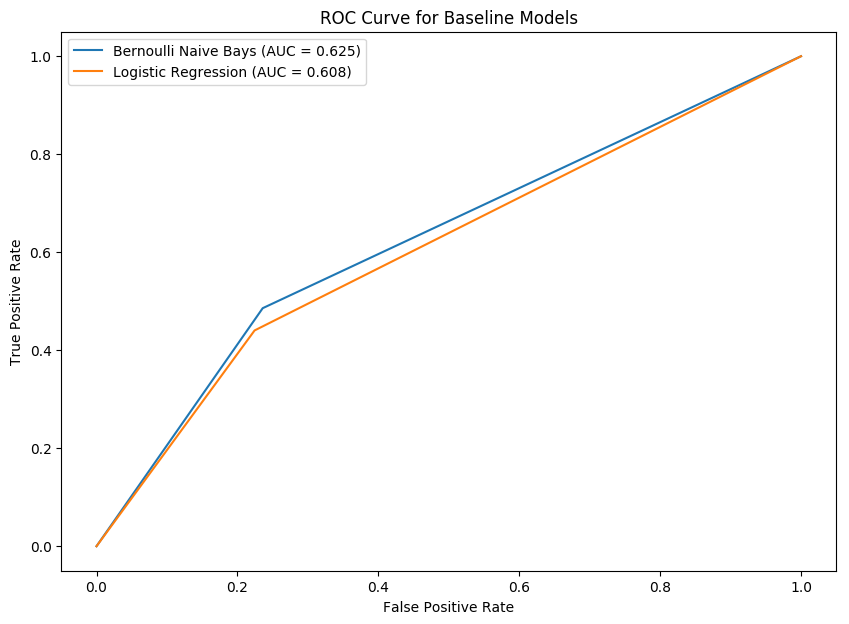

<Figure size 1000x700 with 0 Axes>

In [58]:
plot_aucs("ROC Curve for Baseline Models", y_test, [(nb_preds[0][0], "Bernoulli Naive Bays"), (lrs[4].predict(X_test), "Logistic Regression")])

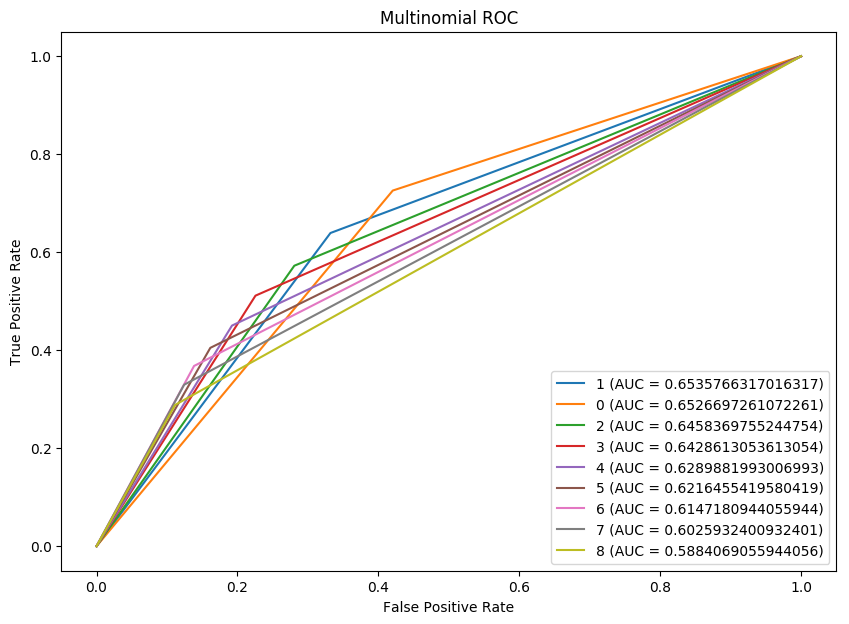

In [24]:
plot_aucs("Multinomial ROC", y_test, mb_preds[1])

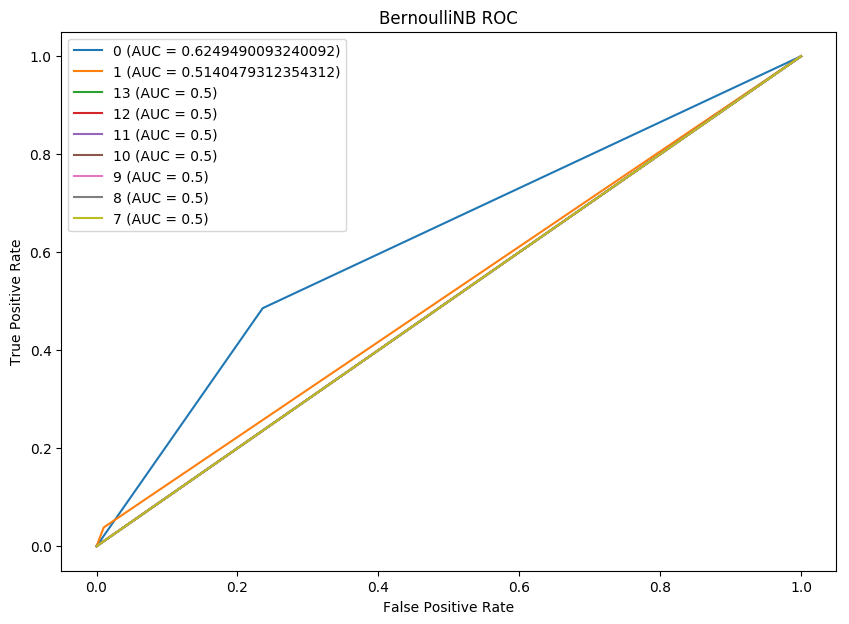

In [27]:
plot_aucs("BernoulliNB ROC", y_test, nb_preds)

In [14]:
def train(models):
    trained = []
    for model, name in models:
        model.fit(X_train, y_train)
        trained.append(model)
        acc = model.score(X_test, y_test) * 100
        print("{}: {:.2f}% Accuracy".format(name, acc))
    
    return trained

In [57]:
def plot_aucs(title, y, y_hs):
    aucs = []
    d = []
    for y_h, label in y_hs:
        fpr, tpr, _ = roc_curve(y, y_h)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        d.append((fpr, tpr))
    for idx in np.argsort(aucs)[::-1][:9]: 
        fpr, tpr = d[idx]
        plt.plot(fpr, tpr, label = "{} (AUC = {:.3f})".format(y_hs[idx][1], aucs[idx]))
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.show()
    plt.savefig("baseline_roc.png")
    


In [34]:
models = [
    (lr, "Logistic Regression"),
    (rf, "Random Forest"),
    (mnb, "Multinomial Naive Bayes"),
    (bnb, "Bernoulli Naive Bayes"),
    (svm, "SVM"),
    (knn, "K Nearest Neighbors")
]

In [35]:
trained = train(models)

Logistic Regression: 61.12% Accuracy
Random Forest: 59.57% Accuracy
Multinomial Naive Bayes: 59.97% Accuracy
Bernoulli Naive Bayes: 55.32% Accuracy
SVM: 52.56% Accuracy


KeyboardInterrupt: 

In [ ]:
y_hs = [(model.predict(X_test), models[i][1]) for i, model in enumerate(trained)]

In [ ]:
plot_aucs(y_test, y_hs)

In [28]:
def train_lr():
    solvers_l2 = ["lbfgs", "newton-cg", "sag"]
    solvers_l1 = ["liblinear", "saga"]
    multi_class = ["multinomial", 'ovr']
    penalties = ["l1", "l2"]
    Cs = [1, 1.5, 2]
    
    models = []
    for solver in solvers_l2:
        for C in Cs:
            for cls in multi_class:
                model = LogisticRegression(solver = solver, penalty = "l2", C = C, random_state = 42, n_jobs = cpu_count(), multi_class=cls)
                models.append((model, "{}_{}_{}_{}".format(solver, "l2", C, cls)))
            
    for solver in solvers_l1:
        for penalty in penalties:
            for C in Cs:
                if solver == "sag":
                    for cls in multi_class:
                        model = LogisticRegression(solver = solver, penalty = penalty, C = C, random_state = 42, n_jobs = cpu_count(), multi_class=cls)
                        models.append((model, "{}_{}_{}_{}".format(solver, penalty, C, cls)))
                else:
                    model = LogisticRegression(solver = solver, penalty = penalty, C = C, random_state = 42, n_jobs = cpu_count())
                    models.append((model, "{}_{}_{}".format(solver, penalty, C)))
    return train(models)    

In [29]:
lrs = train_lr()

lbfgs_l2_1_multinomial: 61.12% Accuracy
lbfgs_l2_1_ovr: 58.49% Accuracy
lbfgs_l2_1.5_multinomial: 61.32% Accuracy
lbfgs_l2_1.5_ovr: 60.11% Accuracy
lbfgs_l2_2_multinomial: 61.66% Accuracy
lbfgs_l2_2_ovr: 61.12% Accuracy
newton-cg_l2_1_multinomial: 61.12% Accuracy
newton-cg_l2_1_ovr: 58.49% Accuracy
newton-cg_l2_1.5_multinomial: 61.32% Accuracy
newton-cg_l2_1.5_ovr: 60.11% Accuracy
newton-cg_l2_2_multinomial: 61.59% Accuracy
newton-cg_l2_2_ovr: 61.12% Accuracy
sag_l2_1_multinomial: 61.12% Accuracy
sag_l2_1_ovr: 58.49% Accuracy
sag_l2_1.5_multinomial: 61.32% Accuracy
sag_l2_1.5_ovr: 60.11% Accuracy
sag_l2_2_multinomial: 61.59% Accuracy
sag_l2_2_ovr: 61.12% Accuracy
liblinear_l1_1: 52.36% Accuracy


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


liblinear_l1_1.5: 56.13% Accuracy
liblinear_l1_2: 58.76% Accuracy
liblinear_l2_1: 58.56% Accuracy
liblinear_l2_1.5: 60.04% Accuracy
liblinear_l2_2: 61.12% Accuracy
saga_l1_1: 52.36% Accuracy
saga_l1_1.5: 56.06% Accuracy


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


saga_l1_2: 58.76% Accuracy
saga_l2_1: 58.49% Accuracy
saga_l2_1.5: 60.11% Accuracy
saga_l2_2: 61.12% Accuracy


In [30]:
preds = [(lr.predict(X_test), i) for i, lr in enumerate(lrs)]

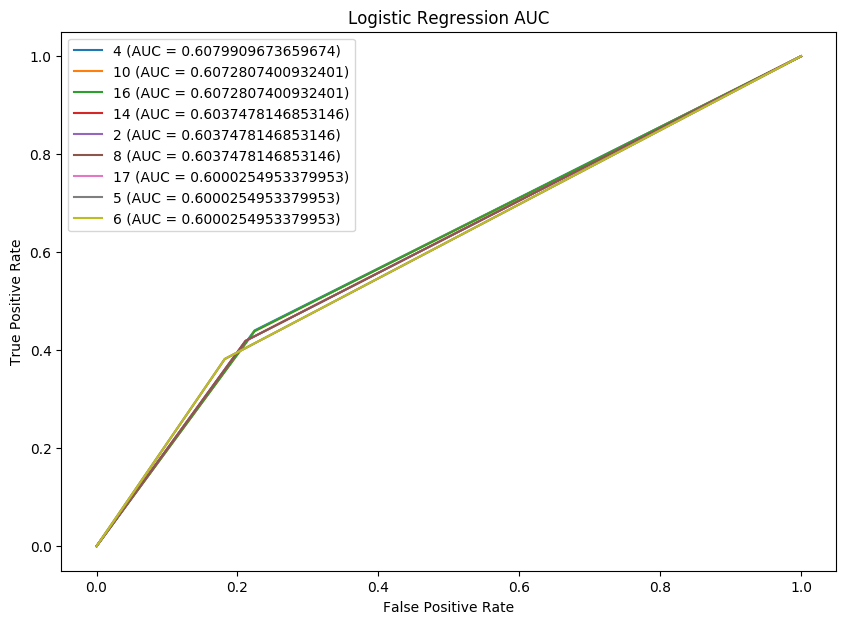

In [31]:
plot_aucs("Logistic Regression AUC", y_test, preds)

In [ ]:
# train_svc()

linear__1e-07__ovo__True: 63.99% Accuracy
linear__1e-07__ovo__False: 63.99% Accuracy
linear__1e-07__ovr__True: 63.99% Accuracy
linear__1e-07__ovr__False: 63.99% Accuracy
linear__1e-06__ovo__True: 63.99% Accuracy
linear__1e-06__ovo__False: 63.99% Accuracy
linear__1e-06__ovr__True: 63.99% Accuracy
linear__1e-06__ovr__False: 63.99% Accuracy
linear__1e-05__ovo__True: 63.99% Accuracy
linear__1e-05__ovo__False: 63.99% Accuracy
linear__1e-05__ovr__True: 63.99% Accuracy
linear__1e-05__ovr__False: 63.99% Accuracy
linear__0.0001__ovo__True: 63.99% Accuracy
linear__0.0001__ovo__False: 63.99% Accuracy
linear__0.0001__ovr__True: 63.99% Accuracy
linear__0.0001__ovr__False: 63.99% Accuracy
linear__0.001__ovo__True: 63.99% Accuracy
linear__0.001__ovo__False: 63.99% Accuracy
linear__0.001__ovr__True: 63.99% Accuracy
linear__0.001__ovr__False: 63.99% Accuracy
linear__0.01__ovo__True: 63.99% Accuracy
linear__0.01__ovo__False: 63.99% Accuracy
linear__0.01__ovr__True: 63.99% Accuracy
linear__0.01__ovr__Fal

In [15]:
neighbors = range(5, 25)

In [ ]:
knn_models = [(KNeighborsClassifier(n_neighbors = neighbor, weights = "distance", n_jobs = cpu_count()), "KNN ({} neighbors)".format(neighbor)) for neighbor in neighbors]
train(knn_models)

In [ ]:
knn_models = [(KNeighborsClassifier(n_neighbors = neighbor, weights = "uniform", p = 1, n_jobs = cpu_count()), "KNN ({} neighbors)".format(neighbor)) for neighbor in neighbors]
train(knn_models)

In [ ]:
def train_nb():
    